## Modules à importer

In [1]:
import math
import scipy
import pickle
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from snprop import survey
from variaIa import tools
from variaIa.tools import surveys, df_cons, df_nc, df_c, df_full
from variaIa import massevol
from importlib import reload
from variaIa import stretchevol
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import random

## Définitions pandas, surveys et sélection de l'échantillon à utiliser

In [2]:
def set_survey(cons, su):
    global df
    if su == 'All':
        df = df_cons(cons)
    elif 'n' in su:
        df = df_cons(cons)[df_cons(cons)['survey'] != su.split('n')[-1]]
    else:
        df = df_cons(cons)[df_cons(cons)['survey'] == su]

int_set_su = ipw.interactive(set_survey, cons=tools.cons, su=tools.su)
display(int_set_su)

smap = plt.cm.get_cmap('cividis')
colors = {'SNF': plt.cm.binary(0.9),
          'SDSS': smap(0.1),
          'PS1': smap(0.5),
          'SNLS': smap(0.8),
          'HST': smap(0.99)}  # for cividis
          #'HST': smap(300)}  # for viridis

alphacolors = {'1': {survey:
                     (colors[survey][0], colors[survey][1], colors[survey][2], .1)
                     for survey in surveys},
               '3': {survey:
                     (colors[survey][0], colors[survey][1], colors[survey][2], .3)
                     for survey in surveys},
               '5': {survey:
                     (colors[survey][0], colors[survey][1], colors[survey][2], .5)
                     for survey in surveys},
               '8': {survey:
                     (colors[survey][0], colors[survey][1], colors[survey][2], .8)
                     for survey in surveys}} 

df_nHST = df_nc[df_nc['survey'] != 'HST']

interactive(children=(Checkbox(value=False, description='Conservative'), Dropdown(description='Survey:', index…

## Use of `massevol` to determine a mass/age relationship

In [6]:
massmodelAGG = massevol.Evol3G3M4S(df)
massmodelAGG.minimize(limit_a=(0,1), limit_mu_2=(8, 10), limit_mu=(10, 11))
massmodelAGG.param

{'mu_1': 9.402120531476637,
 'sigma_1': 0.6252631116778261,
 'a': 0.21271318064176492,
 'mu_2': 9.757650250815667,
 'sigma_2': 1.051571624592359,
 'mu': 10.661142900294456,
 'sigmadown': 0.37272833778544867,
 'sigmaup': 0.2916274414602597}

In [10]:
massmodelGGG = massevol.Evol3G3M3S(df)
massmodelGGG.minimize(limit_a=(0,1))
massmodelGGG.param

{'mu_1': 9.40726811874135,
 'sigma_1': 0.6228196947194393,
 'a': 0.8978081699778082,
 'mu_2': 10.596614330808425,
 'sigma_2': 0.38052028203200633,
 'mu_3': 8.745010425206827,
 'sigma_3': 0.42958846271536766}

In [3]:
massmodelGG = massevol.Evol2G2M2S(df)
massmodelGG.minimize()
massmodelGG.param

{'mu_1': 9.339838355365332,
 'sigma_1': -0.6319173460221872,
 'mu_2': 10.582249490536746,
 'sigma_2': -0.39445919525975626}

In [5]:
massmodelGG.get_aic()

232.79569405466142

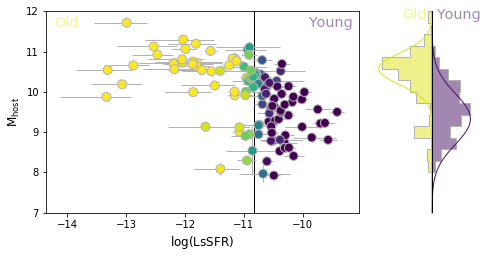

In [7]:
fig = plt.figure(figsize=[7, 3.5])
ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])
axh = fig.add_axes([0.75, 0.12, 0.2, 0.8])

dgmap = plt.cm.get_cmap('viridis')
dg_colors = [dgmap(i, 1) for i in (1-df.py)]

massmodelGG.scatter(ax=ax, model=False)
massmodelGG.show_hist(ax=axh)
massmodelGG.show_model(ax=axh,
                     o_factor=-massmodelGG.amp*np.sum(1-massmodelGG.py),
                     y_factor=massmodelGG.amp*np.sum(massmodelGG.py),
                     facealpha=0, edgealpha=1, lw=1, zorder=8)

axh.set_ylim(*ax.get_ylim())
axh.set_yticks([])
axh.set_xticks([])

axh.axvline(0, color='k', lw=1, zorder=10)

axh.set_frame_on(False)

fig.savefig('../../Images/pdf/model_mass_' + massmodelGG.__doc__ + '_hist.pdf', bbox_inches='tight')
fig.savefig('../../Images/png/model_mass_' + massmodelGG.__doc__ + '_hist.png', bbox_inches='tight', dpi=600)

## Individual mass histogram

Text(0, 0.5, '$\\mathrm{N}_\\mathrm{SNe Ia}$ ')

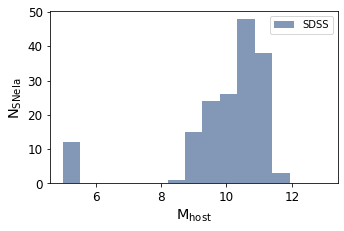

In [23]:
fig = plt.figure(figsize=[5, 3])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

ax.hist(df.hostmass,
        range=[5, 13], bins=15,
        histtype='stepfilled',
        color=colors[su.value],
        alpha=.5, lw=2, label=su.value)

ax.tick_params(labelsize=12)

ax.legend()

ax.set_xlabel(r"$\mathrm{M}_\mathrm{host}$", fontsize="x-large")
ax.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$ ", fontsize="x-large")

## Total mass fitting tests

### One asym

In [19]:
def gauss(M, mu, sigma, normed=True):
    '''Le modèle de distribution'''
    sigma_eff = np.sqrt(sigma**2)
    norm = 1 if normed else np.sqrt(2*np.pi)*sigma_eff
    return norm*scipy.stats.norm.pdf(M, mu, scale=sigma_eff)

def likelihood_asym(M, mu, sigma_m, sigma_p):
    '''La fonction prenant en compte la probabilité d'être vieille/jeune'''
    flag_up = M >= mu
    likelihood = np.zeros(len(M))
    likelihood[flag_up] = gauss(M[flag_up],
                                mu, sigma_p, normed=False)
    likelihood[~flag_up] = gauss(M[~flag_up],
                                 mu, sigma_m, normed=False)
    norm = np.sqrt(2*np.pi)*(0.5*np.sqrt(sigma_m**2)
                             + 0.5*np.sqrt(sigma_p**2))
    return likelihood/norm

def loglikelihood_asym(mu, sigma_m, sigma_p):
    '''La fonction à minimiser'''
    return -2*np.sum(np.log(likelihood_asym(df_nHST[df_nHST['hostmass'] > 7].hostmass,
                                            mu,
                                            sigma_m, sigma_p)))

def minimize_asym(print_level=0, **kwargs):
    '''Renvoie la meilleure valeur des paramètres'''
    m_tot = im.Minuit(loglikelihood_asym,
                      print_level=print_level,
                      pedantic=False,
                      mu=10, sigma_m=2, sigma_p=1,
                      **kwargs)
    migrad_out = m_tot.migrad()
    return(m_tot)

bestfit_asym = minimize_asym().values

### One asym one Gauss

In [20]:
def likelihood_gauss(M, mu_2, sigma_2):
    '''La fonction décrivant le modèle des SNe vieilles'''
    return gauss(M, mu_2, sigma_2)
                                                                            
def likelihood_asymgauss(a, M, mu, sigma_m, sigma_p, mu_2, sigma_2):
    '''La fonction prenant en compte la probabilité d'être vieille/jeune'''
    return a*likelihood_asym(M, mu, sigma_m, sigma_p) + \
        (1-a)*likelihood_gauss(M, mu_2, sigma_2)
                                                                            
def loglikelihood_asymgauss(a, mu, sigma_m, sigma_p, mu_2, sigma_2):
    '''La fonction à minimiser'''
    return -2*np.sum(np.log(likelihood_asymgauss(a,
                                                 df_nHST[df_nHST['hostmass'] > 7].hostmass,
                                                 mu, sigma_m, sigma_p,
                                                 mu_2, sigma_2)))

def minimize_asymgauss(print_level=0, **kwargs):
    '''Renvoie la meilleure valeur des paramètres'''
    m_tot = im.Minuit(loglikelihood_asymgauss,
                      print_level=print_level,
                      pedantic=False,
                      a=0.5,
                      mu=8, sigma_m=1, sigma_p=0.5,
                      mu_2=11, sigma_2=1,
                      **kwargs)
    migrad_out = m_tot.migrad()
    return(m_tot)

bestfit_asymgauss = minimize_asymgauss().values

### Plotting the tests

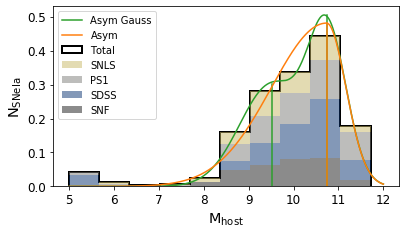

In [21]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.6, 0.5])
    
stacked_bt = [df_nHST[df_nHST['survey'] == survey].hostmass for survey in surveys[:-1]]
hstclrs_bt = [list(alphacolors['5'].values())[i] for i in range(len(surveys[:-1]))]

ax.hist(df_nHST.hostmass,
        density=True,
        bins=10,
        histtype='step',
        lw=2, color='k',
        label='Total')

_, rang, _ = ax.hist(stacked_bt,
                     density=True,
                     stacked=True,
                     bins=10,
                     histtype='stepfilled',
                     color=hstclrs_bt,
                     label=surveys)

ax.tick_params(labelsize=12)

ax.set_xlabel(r'$\mathrm{M}_\mathrm{host}$', fontsize = 'x-large')
ax.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize="x-large")

ax.legend(loc='upper left', fontsize='medium', ncol=1)

path = '../../Images/'
name = 'mass-cut_hist_stac'
pathpdf = path + 'pdf/' + name + '.pdf'
pathpng = path + 'png/' + name + '.png'
fig.savefig(pathpdf, bbox_inches='tight')
fig.savefig(pathpng, bbox_inches='tight', dpi=600)

M_lin = np.linspace(rang[0], 12, 3000)

pdf_asymgauss = likelihood_asymgauss(bestfit_asymgauss['a'],
                                     M_lin,
                                     bestfit_asymgauss['mu'],
                                     bestfit_asymgauss['sigma_m'],
                                     bestfit_asymgauss['sigma_p'],
                                     bestfit_asymgauss['mu_2'],
                                     bestfit_asymgauss['sigma_2'])
ax.plot(M_lin, pdf_asymgauss,
        color='C2', label='Asym Gauss')

ax.vline(bestfit_asymgauss['mu'],
         color='C2',
         ymin=0, ymax=bestfit_asymgauss['a']*\
                      np.max(likelihood_asym(M_lin,
                                             bestfit_asymgauss['mu'],
                                             bestfit_asymgauss['sigma_m'],
                                             bestfit_asymgauss['sigma_p'])))

ax.vline(bestfit_asymgauss['mu_2'],
         color='C2',
         ymin=0, ymax=np.max(pdf_asymgauss))

pdf_asym = likelihood_asym(M_lin,
                           bestfit_asym['mu'],
                           bestfit_asym['sigma_m'],
                           bestfit_asym['sigma_p'])

ax.plot(M_lin, pdf_asym,
        color='C1', label='Asym')
ax.vline(bestfit_asym['mu'],
         color='C1',
         ymin=0, ymax=np.max(pdf_asym))

ax.legend(loc='upper left', fontsize='medium', ncol=1)

path = '../../Images/'
name = 'mass-cut_hist_stac-fit'
pathpdf = path + 'pdf/' + name + '.pdf'
pathpng = path + 'png/' + name + '.png'
fig.savefig(pathpdf, bbox_inches='tight')
fig.savefig(pathpng, bbox_inches='tight', dpi=600)